# **Maestría en Inteligencia Artificial Aplicada**

## **Curso: Inteligencia Artificial y Aprendizaje Automático**

**Tecnológico de Monterrey**

Prof Luis Eduardo Falcón Morales

### **Actividad: Problema de Clasificación con Datos Desbalanceados**

* #### **Nombre:** Liliana Irais Beltrán Martínez
* #### **Matrícula:** A01797565

# **Introducción**

* La actividad se basa en los datos conocidos como "oil-spill" (derrame de petróleo).

* En la web puedes encontrar otros archivos del mismo problema pero con diversos cambios, por lo que el archivo con el que trabajarás está en Canvas y así poder asegurar que todos están trabajando con los mismos datos. Aún en una misma página, con el tiempo se actualiza y los datos inclusive pueden ya no estar accesibles.

* El archivo de los datos con el que trabajarás está en Canvas con el nombre "oil-spill.csv".

En la siguiente liga se encuentra el artículo original relacionado a dicha base de datos. Los datos incluyen 50 columnas y 937 registros. Las primeras 49 columnas son métricas obtenidas de imágenes satelitales del océano, en algunas de las cuales se tiene petróleo que fue derramado por alguna fuente desconocida. En el artículo se describe a detalle la manera en que se obtuvieron dichas columnas. Para la actividad es suficiente considerarlas como de valor numérico, donde cada valor es una medida de información en la imagen. La última columna llamada "target" es de valor 1 (hay derrame en ese pedazo de la imagen) o 0 (no hay derrame en ese pedazo de la imagen).

https://webdocs.cs.ualberta.ca/~holte/Publications/oilspill.pdf

Por el momento es suficiente con que consideres que cada una de las 49 columnas te da información de la imagen que te ayuda a entenderla mejor. En un curso posterior de visión computacional podrás ahondar sobre cómo extraer información numérica de una imagen.

En la siguiente liga puedes encontrar información de varias de las métricas de scikit-learn que estaremos utilizando:

https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

La librería de scikit-learn no incluye la media geométrica **G_mean**, pero sabemos que se puede obtener con la fórmula $G_{mean}=\sqrt{\frac{VP*VN}{(VP+FN) * (VN+FP)}}$, usando los verdaderos y falsos, positivos y negativos.

Sin embargo, para fines de esta actividad usaremos la librería llamada "imbalanced-learn" que incluye dicha métrica, además de un reporte más extenso de otras métricas útiles para estos casos de datos desbalanceados:

https://glemaitre.github.io/imbalanced-learn/generated/imblearn.metrics.geometric_mean_score.html

**Ejercicio-1**




### **En esta actividad usaremos la media geométrica G_mean como métrica principal para buscar el mejor modelo. Explica a continuación cuándo se recomienda utilizar **G_mean** en un problema de aprendizaje supervisado (a) y su diferencia o diferencias con **f1_score** (b):**

**+++++++++++ Inicia sección para agregar texto ++++++++++++++++**


* a) La métrica **G-mean** dará mayor importancia a la clase minoritaria, aunque no estará castigando tanto el promedio, Por lo tanto, la métrica **G-mean** es más adecuada cuando las clases son no balanceadas, al menos un 80%-20% aproximadamente cuando se busca maximizar el recall en todas las clases.

* b) La métrica **F1 Score**, pondera de manera igualmente importante a las dos clases de un problema binario, por ello esta métrica tendrá un mal desempeño cuando una de sus clases tiene mayor importancia que la otra. El **F1-Score** es la media armónica de la precisión y la sensibilidad, y es útil cuando la precisión y la sensibilidad son igualmente importantes. **El G-mean**, en cambio, se centra en el rendimiento de cada clase y lo equilibra.

**+++++++++++ Termina sección para agregar texto ++++++++++++++**

In [41]:
# Incluye todas las librerías que consideres adecuadas:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

from sklearn.datasets import make_classification

from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score, precision_score, f1_score
from sklearn.dummy import DummyClassifier
from imblearn.metrics import geometric_mean_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PowerTransformer, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import make_scorer
from numpy import mean, std
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve, average_precision_score


Para fines de la actividad pre-procesaremos los datos de manera estándar para concentrarnos en los temas relacionados al curso.

In [42]:
# Cargamos los datos del arcivo:
path ='oil_spill.csv'
df = pd.read_csv(path)

# Eliminamos las siguientes columnas:
df.drop("f_1", axis=1, inplace=True)    # Esta columna contiene información de secciones (batches) de las imágenes que no requerimos para esta actividad.
df.drop("f_23", axis=1, inplace=True)   # Esta columna tiene un solo valor constante.

print('Dimensión del DataFrame',df.shape)
df.head(3)


Dimensión del DataFrame (937, 48)


,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,f_10,f_11,...,f_41,f_42,f_43,f_44,f_45,f_46,f_47,f_48,f_49,target
0,2558,1506.09,456.63,90,6395000.0,40.88,7.89,29780.0,0.19,214.7,...,2850.0,1000.0,763.16,135.46,3.73,0,33243.19,65.74,7.95,1
1,22325,79.11,841.03,180,55812500.0,51.11,1.21,61900.0,0.02,901.7,...,5750.0,11500.0,9593.48,1648.80,0.60,0,51572.04,65.73,6.26,0
2,115,1449.85,608.43,88,287500.0,40.42,7.34,3340.0,0.18,86.1,...,1400.0,250.0,150.00,45.13,9.33,1,31692.84,65.81,7.84,1


In [43]:
# Particionamos en los datos de entrada (X) y de salida (y):
X,y = df.iloc[:,:-1], df.iloc[:,-1]

# Utilizamos las semillas indicadas para la reproducibilidad de los resultados:
Xtv, Xtest, ytv, ytest = train_test_split(X, y, test_size=0.12, stratify=y, shuffle=True, random_state=1)
Xtrain, Xval, ytrain, yval = train_test_split(Xtv, ytv, test_size=0.2, shuffle=True, random_state=7)


# Veamos la partición de los tres conjuntos para que observes la poca cantidad de datos que se tienen en la clase minoritaria:
print('\nPartición:')
tmp = 100 * (ytrain.sum() / len(ytrain))
print('Train: Conteo_clase_positiva=%d, Porcentaje_clase_positiva=%.2f%%, Porcentaje_clase_negativa=%.2f%%' % (ytrain.sum(), tmp, 100-tmp))
tmp = 100 * (yval.sum() / len(yval))
print('Val: Conteo_clase_positiva=%d, Porcentaje_clase_positiva=%.2f%%, Porcentaje_clase_negativa=%.2f%%' % (yval.sum(), tmp, 100-tmp))
tmp = 100 * (ytest.sum() / len(ytest))
print('Test: Conteo_clase_positiva=%d, Porcentaje_clase_positiva=%.2f, Porcentaje_clase_negativa=%.2f%%%%' % (ytest.sum(), tmp, 100-tmp))


Partición:
Train: Conteo_clase_positiva=28, Porcentaje_clase_positiva=4.25%, Porcentaje_clase_negativa=95.75%
Val: Conteo_clase_positiva=8, Porcentaje_clase_positiva=4.85%, Porcentaje_clase_negativa=95.15%
Test: Conteo_clase_positiva=5, Porcentaje_clase_positiva=4.42, Porcentaje_clase_negativa=95.58%%


#### **Breve descripción numérica y gráfica del conjunto de entrenamiento:**

In [44]:
Xtrain.describe().T

,count,mean,std,min,25%,50%,75%,max
f_2,659.0,350.377845,1.911459e+03,10.00,19.000,63.00,134.000,28526.00
f_3,659.0,692.040516,6.013521e+02,1.92,83.905,646.26,1229.325,1789.13
f_4,659.0,853.822398,5.259526e+02,1.00,435.500,719.81,1238.040,2724.57
f_5,659.0,85.613050,4.564260e+01,0.00,54.000,74.00,120.500,180.00
f_6,659.0,831366.966616,4.158159e+06,71718.00,125000.000,185000.00,337500.000,71315000.00
f_7,659.0,43.517132,1.287405e+01,21.24,33.760,40.35,53.090,82.64
f_8,659.0,9.244294,3.590490e+00,1.21,6.935,8.33,11.045,23.47
f_9,659.0,4094.624431,8.960913e+03,704.00,1332.000,2100.00,3445.000,160740.00
f_10,659.0,0.221730,8.687786e-02,0.02,0.170,0.21,0.260,0.67
f_11,659.0,110.794537,6.187135e+01,41.00,84.400,100.10,116.300,901.70


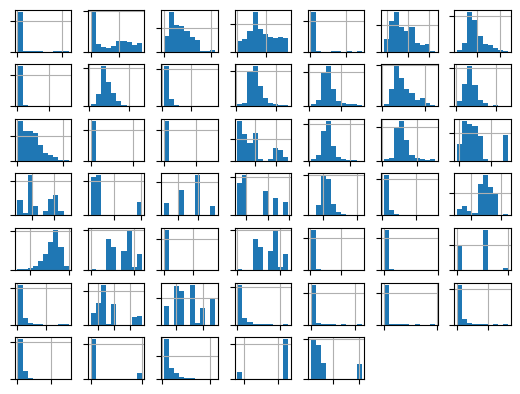

In [45]:
ax = Xtrain.hist()  # Histogramas:
# Quitemos toda la información del gráfico para visualizarlo de manera sencilla:
for axis in ax.flatten():
  axis.set_title('')
  axis.set_xticklabels([])
  axis.set_yticklabels([])
plt.show()


In [46]:
Xtrain.info()

<class 'pandas.core.frame.DataFrame'>
Index: 659 entries, 433 to 625
Data columns (total 47 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f_2     659 non-null    int64  
 1   f_3     659 non-null    float64
 2   f_4     659 non-null    float64
 3   f_5     659 non-null    int64  
 4   f_6     659 non-null    float64
 5   f_7     659 non-null    float64
 6   f_8     659 non-null    float64
 7   f_9     659 non-null    float64
 8   f_10    659 non-null    float64
 9   f_11    659 non-null    float64
 10  f_12    659 non-null    float64
 11  f_13    659 non-null    float64
 12  f_14    659 non-null    float64
 13  f_15    659 non-null    float64
 14  f_16    659 non-null    float64
 15  f_17    659 non-null    float64
 16  f_18    659 non-null    float64
 17  f_19    659 non-null    float64
 18  f_20    659 non-null    float64
 19  f_21    659 non-null    float64
 20  f_22    659 non-null    float64
 21  f_24    659 non-null    float64
 22  f_25 

En resumen:
* De lo anterior observamos que todos los valores ya son numéricos positivos y negativos, no hay datos perdidios, la diferencia de escala entre todos los factores es muy diversa y la distribución de las variables también es muy variada.

* Como una primera aproximación transformaremos todos los factores con la Yeo-Johnson para corregir un poco el sesgo de las distribuciones que suele afectar en general a los modelos como la regresión logística y luego los escalaremos .

# **Ejercicio-2**

### **Investiga: (a) En qué consiste la transformación Yeo-Johnson y (b) cuál es su diferencia con la Box-Cox.**

**+++++++++++ Inicia sección para agregar texto ++++++++++++++++**


* a) La transformación **Yeo Johnson** consiste en una transformación de potencia que puede manejar tanto datos positivos como negativos, haciendo que los datos no normales se aproximen a una distribución normal. Por lo tanto, su propósito es aproximar datos numéricos a una distribución normal, permitiendo su uso en análisis estadísticos que requieren normalidad.

* b) Por otro lado, la transformación **Box-Cox** es un método similar, pero con la restricción de que solo puede aplicarse a datos numéricos estrictamente positivos, no a valores cero o negativos.
La diferencia fundamental Vs. **Yeo-Johnson** radica en el rango de los datos que cada una puede procesar:

* **Yeo-Johnson**: Permite transformar datos con valores positivos, negativos y cero.
* **Box-Cox**: Requiere que los datos de entrada sean estrictamente positivos; no funciona con cero ni valores negativos.



**+++++++++++ Termina sección para agregar texto ++++++++++++++**

In [47]:
# Código-1:

# Aplicamos la función Dummy con la métrica G-mean:

def evaluate_model(X, y, model):
  cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
  metric = make_scorer(geometric_mean_score)
  scores = cross_val_score(model, X, y, scoring=metric, cv=cv, n_jobs=-1)
  return scores


modeloD = DummyClassifier(strategy='uniform', random_state=7)
scores = evaluate_model(Xtrain, ytrain, modeloD)


print('Métrica G-mean[Media Geométrica] y (std): %.3f (%.3f)' % (mean(scores), std(scores)))


Métrica G-mean[Media Geométrica] y (std): 0.461 (0.237)


# **Ejercicio-3**

### **Explica lo que hace cada línea de código de la celda anterior llamada "Código-1", así como el significado de los valores que se obtienen en la salida:**

**+++++++++++ Inicia sección para agregar texto ++++++++++++++++**

**NOTA AL PROFESOR: la descripción puede ser algo diferente a lo que comento aquí:**


1.   Declara la función para evaluar los datos, la función se llamará "Evaluate Model" con "X" como variables independientes, "Y" como variable dependiente u objetivo.
2.   Define la estrategia de validación "StratifiedKFold" que consiste en dividir los datos manteniendo la proporción de clases. Usa 10 particiones: n_splits=10 y repite el proceso 3 veces: n_repeats=3 y asegura que se repitan de manera aleatoria random_state=1
3.   Convierte la función en "geometric_mean_score" para evaluar el rendimiento considerando el balance entre clases
4.   Ejecuta el modelo, usando las funciones y variables definidas del elemento 1 al 3, y con "n_jobs=-1" usa todos los núcleos disponibles para acelerar el cálculo
5.   Devuelve 30 valores
6.   Define un modelo de referencia con la función "Dummmy Clasifier" que se usa como una línea base para comparar con modelos reales y "strategy='uniform'" predice clases de manera uniforme sin aprender nada de los datos.
7.   Evalúa el rendimiento del modelo dummy en los datos de entrenamiento (Xtrain, ytrain) usando la métrica de "geometric mean" y validación cruzada repetida
8.   Devuelve un array con los resultados de cada partición o fold
9.   Significado del valor de salida: el rendimiento promedio del modelo es medio/ bajo "0.46", es decir que tiene poca capacidad para clasificar correctamente ambas clases. También tiene una variabilidad de .237 que significa que las particiones o folds contienen distribuciones muy diferentes


**+++++++++++ Termina sección para agregar texto ++++++++++++++**

#### **Para fines de esta actividad definimos las siguientes transformaciones del preprocesamiento de los datos. Recuerda que aunque estos datos no tengan datos perdidos, simpre debes incluir una opción para el caso con datos futuros:**

In [48]:
# Transforamaciones numéricas que evitará el filtrado de información:


numericas_pipeline = Pipeline(steps = [('impMediana', SimpleImputer(strategy='mean')),
                                       ('yeo-johnson', PowerTransformer()),
                                       ('std_transformer', StandardScaler()),
                                       ])

numericas_pipeline_nombres = Xtrain.columns

columnasTransformer = ColumnTransformer(transformers = [('num', numericas_pipeline, numericas_pipeline_nombres)],
                                        remainder='passthrough')

In [49]:
mi_metrica = make_scorer(geometric_mean_score)  # definimos la métrica G-mean

Resultados de Validación:
LR
Exactitud: >> 0.947 (0.015)
G-mean: >> 0.654 (0.119)

LASSO
Exactitud: >> 0.960 (0.009)
G-mean: >> 0.501 (0.158)

RIDGE
Exactitud: >> 0.959 (0.008)
G-mean: >> 0.541 (0.113)

EN
Exactitud: >> 0.960 (0.007)
G-mean: >> 0.540 (0.109)

kNN
Exactitud: >> 0.956 (0.006)
G-mean: >> 0.174 (0.187)



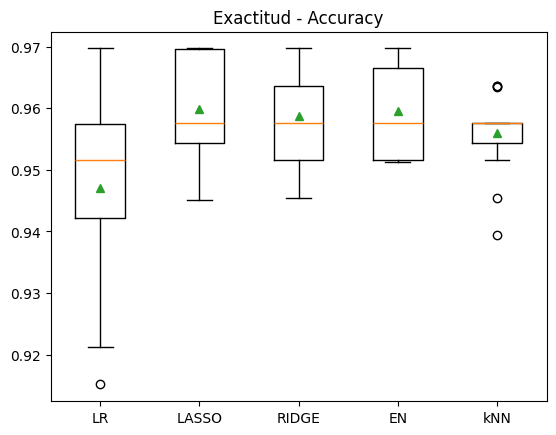

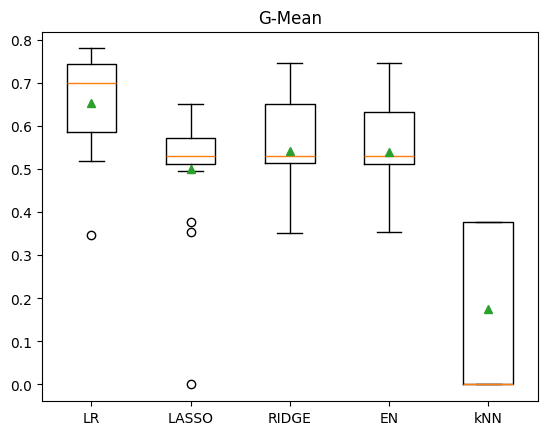

In [50]:
# Código-2:


def mis_modelos1():
  modelos, nombres = list(), list()

  modelos.append(LogisticRegression(penalty=None,
                                    max_iter=2000,
                                    random_state=1))
  nombres.append('LR')


  modelos.append(LogisticRegression(penalty='l1',
                                    solver='liblinear',
                                    max_iter=2000,
                                    random_state=1))
  nombres.append('LASSO')


  modelos.append(LogisticRegression(penalty='l2',
                                    max_iter=2000,
                                    random_state=1))
  nombres.append('RIDGE')

  modelos.append(LogisticRegression(penalty='elasticnet',
                                    l1_ratio=0.5,
                                    solver='saga',
                                    max_iter=5000,
                                    random_state=1))
  nombres.append('EN')

  modelos.append(KNeighborsClassifier(n_neighbors=5))
  nombres.append('kNN')

  return modelos, nombres

# +++++++++++++++++++++++++++++++


modelos, nombres = mis_modelos1()
resultados1, resultados2 = list(), list()
print('Resultados de Validación:')

for i in range(len(modelos)):

  pipeline = Pipeline(steps=[('ct',columnasTransformer),('m',modelos[i])])
  cv1 = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=7)
  scores = cross_validate(pipeline,
                          Xtv,
                          np.ravel(ytv),
                          scoring={'exactitud':'accuracy', 'm_geo':mi_metrica},
                          cv=cv1)

  resultados1.append(scores['test_exactitud'])
  resultados2.append(scores['test_m_geo'])

  print(nombres[i])
  print('Exactitud: >> %.3f (%.3f)' % (np.nanmean(scores['test_exactitud']), np.nanstd(scores['test_exactitud'])))
  print('G-mean: >> %.3f (%.3f)' % (np.nanmean(scores['test_m_geo']), np.nanstd(scores['test_m_geo'])))
  print()

plt.boxplot(resultados1, tick_labels=nombres,  showmeans=True)
plt.title("Exactitud - Accuracy")
plt.show()

plt.boxplot(resultados2, tick_labels=nombres,  showmeans=True)
plt.title("G-Mean")
plt.show()


# **Ejercicio-4**

### **a) Explica por qué la salida y gráficos anteriores nos ayudan a respaldar la decisión de usar la métrica G-mean, en lugar de la exactitud (accuracy) en este problema.**

### **b) En particular, indica cuáles de los modelos que obtuviste están subentrenados con respecto a la métrica de la exactitud (accuracy), en caso de que haya.**

### **c) Indica cuáles de los modelos que obtuviste están subentrenados con respecto a la métrica de la media geométrica, en caso de haya.**

**+++++++++++ Inicia sección para agregar texto ++++++++++++++++**

* a) Casi todos los modelos tienen mayor variabilidad con la métrica accuracy que con la métrica G-mean

* b) Al parecer, ningún modelos está subentrenado ya que tienen una exactitud alta y STD baja

* c) El modelo KNN está subentrenado ya que tiene una media geométrica muy baja y una variación muy alta. Por otro lado LASSO, RIDGE y EN, también parecen estar subentrenados pero en menor medida que KNN


**+++++++++++ Termina sección para agregar texto ++++++++++++++**

# **Ejercicio-5**

* ### **Utilizando en adelante solamente la métrica G-mean y de manera análoga al código de la celda llamada "Código-2" anterior, define una nueva función llamada "mis_modelos_balanceados()" y utilízala para definir los mismos modelos anteriores, pero incluyendo el argumento class_weight='balanced'.**

* ### **Los demás hiperparámetros solo debes variarlos si es necesario, es decir, solo deberás ajustarlos para evitar errores o avisos (warnings) no deseados.**

* ### **Incluye también el modelo kNN, aunque no tenga el argumento para balanceo de las clases.**

Resultados de Validación (Balanceados):
LR_bal
G-mean: >> 0.754 (0.120)

LASSO_bal
G-mean: >> 0.804 (0.081)

RIDGE_bal
G-mean: >> 0.801 (0.083)

EN_bal
G-mean: >> 0.799 (0.083)

kNN
G-mean: >> 0.174 (0.187)



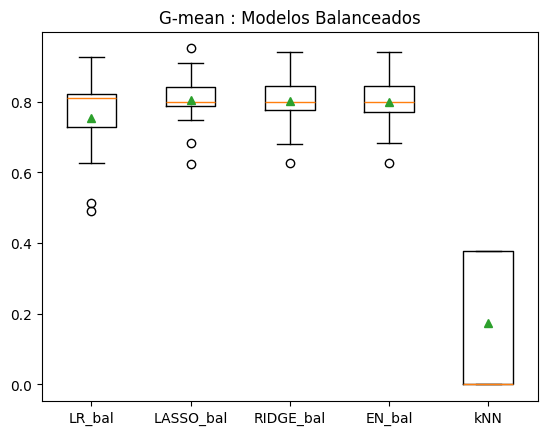

In [51]:
# ++++++++++ Inicia sección para agregar tu código ++++++++++++++++++++++++

def mis_modelos_balanceados():
    modelos, nombres = list(), list()

    # 1. Logistic Regression sin penalización (balanceado)
    modelos.append(LogisticRegression(
        penalty=None,
        max_iter=2000,
        class_weight='balanced',
        random_state=1
    ))
    nombres.append('LR_bal')

    # 2. LASSO (L1) balanceado
    modelos.append(LogisticRegression(
        penalty='l1',
        solver='liblinear',
        max_iter=2000,
        class_weight='balanced',
        random_state=1
    ))
    nombres.append('LASSO_bal')

    # 3. RIDGE (L2) balanceado
    modelos.append(LogisticRegression(
        penalty='l2',
        max_iter=2000,
        class_weight='balanced',
        random_state=1
    ))
    nombres.append('RIDGE_bal')

    # 4. Elastic Net (L1 + L2) balanceado
    modelos.append(LogisticRegression(
        penalty='elasticnet',
        l1_ratio=0.5,
        solver='saga',
        max_iter=5000,
        class_weight='balanced',
        random_state=1
    ))
    nombres.append('EN_bal')

    # 5. kNN (no tiene class_weight directamente)
    modelos.append(KNeighborsClassifier(n_neighbors=5))
    nombres.append('kNN')

    return modelos, nombres

modelos2, nombres2 = mis_modelos_balanceados()
resultados_balanceados = list()
print('Resultados de Validación (Balanceados):')

for i in range(len(modelos2)):

  pipeline = Pipeline(steps=[('ct',columnasTransformer),('m',modelos2[i])])
  cv1 = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=7)
  scores = cross_validate(pipeline,
                          Xtv,
                          np.ravel(ytv),
                          scoring={'m_geo':mi_metrica},
                          cv=cv1)

  resultados_balanceados.append(scores['test_m_geo'])

  print(nombres2[i])
  print('G-mean: >> %.3f (%.3f)' % (np.nanmean(scores['test_m_geo']), np.nanstd(scores['test_m_geo'])))
  print()


# ++++++++++ Termina sección para agregar tu código ++++++++++++++++++++++++


plt.boxplot(resultados_balanceados, tick_labels=nombres2,  showmeans=True)   # gráficos de caja para una comparación visual de los resultados.
plt.title("G-mean : Modelos Balanceados")
plt.show()

# **Ejercicio-6**

**a) Selecciona el que consideres sea el mejor modelo encontrado, busca la mejor configuración de hiperparámetros y utilízalo para encontrar su matriz de confusión. Sigue utilizando los mismos conjuntos de entrenamiento y validación. Llamar "yval_hat" a las predicciones del conjunto de validación obtenidas con el mejor modelo.**

  **b) Con el mejor modelo obtener el gráfico de la curva-ROC, donde se incluya el valor del área bajo la curva AUC del mejor modelo y también el AUC del modelo base (chance level).**

  **c) Con el mejor modelo obtener el gráfico de la curva-PR, donde se incluya el valor del área bajo la curva AUC del mejor modelo y también el AUC del modelo base (chance level).**



**NOTA: En general cuando comparas modelos con Validación-Cruzada sin un ajuste mayor de hiperparámetros, el mejor modelo podría estar entre los de mayor desempeño y no necesariamente el que resultó con mayor valor. Por ello, en general deberías mantener la búsqueda entre los mejores encontrados.**

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


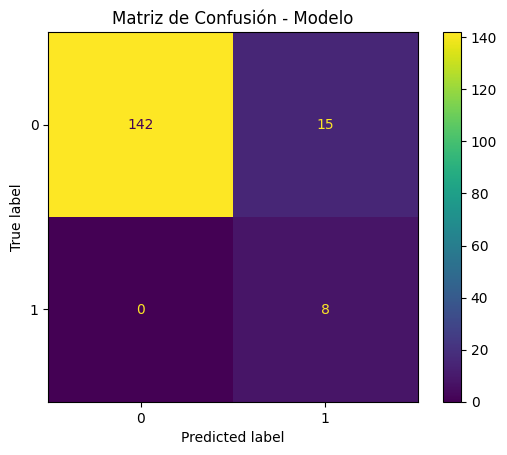

Matriz de confusión (array):
 [[142  15]
 [  0   8]]
G-mean del mejor modelo: 0.9510

Matriz de Confusión:
 [[142  15]
 [  0   8]]


In [52]:
# 6a) Matriz de confusión

# **+++++++++++ Inicia sección para agregar código ++++++++++++++++**
# NOTA: puedes agregar todas las celdas que consideres adecuado.

best_model = LogisticRegression(
    class_weight='balanced',
    penalty=None,
    max_iter=5000,
    random_state=1
)
best_model.fit(Xtrain, ytrain)
yval_hat = best_model.predict(Xval)
yval_proba = best_model.predict_proba(Xval)[:, 1]


cm = confusion_matrix(yval, yval_hat)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Matriz de Confusión - Modelo")
plt.show()

print("Matriz de confusión (array):\n", cm)



print('G-mean del mejor modelo: %.4f' % geometric_mean_score(np.ravel(yval), yval_hat))
print("\nMatriz de Confusión:\n", confusion_matrix(np.ravel(yval), yval_hat))

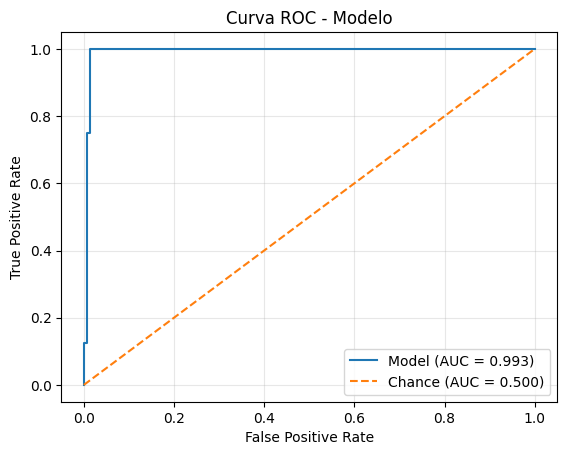

AUC ROC (modelo): 0.9928
AUC ROC (baseline): 0.5000


In [53]:
# 6b) Curva ROC:

# **+++++++++++ Inicia sección para agregar código ++++++++++++++**


fpr, tpr, _ = roc_curve(yval, yval_proba)
auc_roc = roc_auc_score(yval, yval_proba)
auc_roc_baseline = 0.5  # chance level

plt.figure()
plt.plot(fpr, tpr, label=f'Model (AUC = {auc_roc:.3f})')
plt.plot([0, 1], [0, 1], linestyle='--', label=f'Chance (AUC = {auc_roc_baseline:.3f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC - Modelo')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()
print(f"AUC ROC (modelo): {auc_roc:.4f}")
print(f"AUC ROC (baseline): {auc_roc_baseline:.4f}")


# **+++++++++++ Termina sección para agregar código ++++++++++++++**

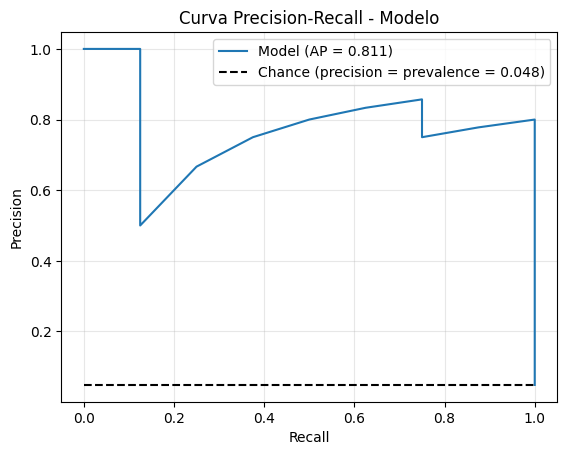

AUC PR (modelo): 0.8106
Baseline AUC PR (chance): 0.0485


In [54]:
# 6c) Curva PR:

# **+++++++++++ Inicia sección para agregar código ++++++++++++++**


precision, recall, _ = precision_recall_curve(yval, yval_proba)
auc_pr = average_precision_score(yval, yval_proba)
pos_rate = np.mean(yval == 1)  # baseline PR = prevalencia clase positiva

plt.figure()
plt.plot(recall, precision, label=f'Model (AP = {auc_pr:.3f})')
plt.hlines(y=pos_rate, xmin=0, xmax=1, colors='k', linestyles='--',
           label=f'Chance (precision = prevalence = {pos_rate:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision-Recall - Modelo')
plt.legend(loc='upper right')
plt.grid(alpha=0.3)
plt.show()

print(f"AUC PR (modelo): {auc_pr:.4f}")
print(f"Baseline AUC PR (chance): {pos_rate:.4f}")


# **+++++++++++ Termina sección para agregar código ++++++++++++++**

# **Ejercicio-7**

### **Utiliza el conjunto de prueba (test) para evaluar el mejor modelo obtenido previamente y obtener:**

**a) El valor de la media geométrica G_mean.**

**b) La matriz de confusión.**

**c) El reporte de métricas classification_report_imbalanced:**



In [55]:
# 7a)

print('G-mean del mejor modelo con el conjunto de prueba (test):')

# **+++++++++++ Inicia sección para agregar código ++++++++++++++++**
# NOTA: puedes agregar todas las celdas que consideres adecuado.

ytest_hat = best_model.predict(Xtest)
gmean_test = geometric_mean_score(ytest, ytest_hat)

print(f"G-mean en el conjunto de prueba: {gmean_test:.4f}")


# **+++++++++++ Termina sección para agregar código ++++++++++++++**

G-mean del mejor modelo con el conjunto de prueba (test):
G-mean en el conjunto de prueba: 0.8692


Matriz de confusión del mejor modelo con el conjunto de prueba (test):


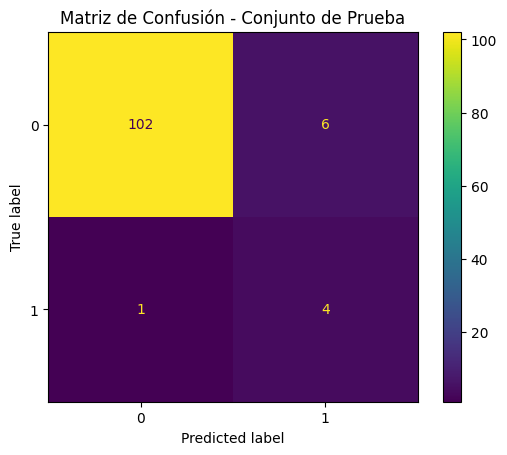

Matriz de confusión (array) en el conjunto de prueba:
 [[102   6]
 [  1   4]]


In [56]:
# 7b)

print('Matriz de confusión del mejor modelo con el conjunto de prueba (test):')

# **+++++++++++ Inicia sección para agregar código ++++++++++++++++**
# NOTA: puedes agregar todas las celdas que consideres adecuado.

cm_test = confusion_matrix(ytest, ytest_hat)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test)
disp_test.plot()
plt.title("Matriz de Confusión - Conjunto de Prueba")
plt.show()

print("Matriz de confusión (array) en el conjunto de prueba:\n", cm_test)


# **+++++++++++ Termina sección para agregar código ++++++++++++++**

In [57]:
# 7c)

print("Reporte de métricas con el conjunto de prueba (test):\n")

# **+++++++++++ Inicia sección para agregar código ++++++++++++++++**
# NOTA: puedes agregar todas las celdas que consideres adecuado.

from imblearn.metrics import classification_report_imbalanced

report_test = classification_report_imbalanced(ytest, ytest_hat)
print(report_test)


# **+++++++++++ Termina sección para agregar código ++++++++++++++**

Reporte de métricas con el conjunto de prueba (test):

                   pre       rec       spe        f1       geo       iba       sup

          0       0.99      0.94      0.80      0.97      0.87      0.77       108
          1       0.40      0.80      0.94      0.53      0.87      0.74         5

avg / total       0.96      0.94      0.81      0.95      0.87      0.77       113



# **Ejercicio-8**

### **Incluye tus conclusiones finales de los resultados obtenidos y de la actividad en general.**

**+++++++++++ Inicia sección para agregar texto ++++++++++++++++**


A pesar de que el uso de la métrica Accuracy parecía arrojar mejores resultados, todos los modelos resultantes estaban sobre entrenados, por otro lado, en el caso de la métrica G- mean, evidenció algunos modelos sub entrenados pero arrojó el mejor modelo al ser la que mide el rendimiento balanceado entre clases.

Una vez identificado que el mejor modelo es el de regresión logística (ya que fue el que mostró el mejor G-mean] Podemos observar una matriz de confusuión con el número más alto en los verdaderos positivos, lo cual refuerza la validez del modelo, este comportamiento se repite en el conjunto de prueba,


**+++++++++++ Termina sección para agregar texto ++++++++++++++**

# **<<< Fin de la Actividad de la Semana - Oil Spill - Clases no balanceadas >>>**